# Data Wrangling Project
Kate Ryan and Alexis Arthur

#### Import the necessary packages

In [4]:
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.by import By # used to import different ways to access data in the XML or HTML file
from selenium.webdriver.chrome.service import Service # no longer need to download a driver file, use service
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
#from selenium.common.exceptions import TimeoutException
#from selenium.common.exceptions import NoSuchElementException

from webdriver_manager.chrome import ChromeDriverManager # used to manage the Chrome driver to emulate a Chrome web browser

import time
import random
import re
import numpy as np

#!pip install webdriver-manager

#### Write the code to crawl and scrape the IMDb website for the Top 250 Movies

In [11]:
# set up the browser
service = Service(ChromeDriverManager().install())
browser = webdriver.Chrome(service=service)
#browser = webdriver.Chrome(ChromeDriverManager().install())
#browser = webdriver.Chrome()
browser.maximize_window()

# initialize the data lists
movie_name = []
year = []
run_time = []
score = []


# open the web page
browser.get("https://www.imdb.com/chart/top/?ref_=nv_mv_250")
time.sleep(1)

# find the movie links
movie_links = browser.find_elements(By.XPATH, '//ul[contains(@class, "ipc-metadata-list")]//li[@class="ipc-metadata-list-summary-item"]//a')
urls = [link.get_attribute("href") for link in movie_links if "/title/" in link.get_attribute("href")]
urls = list(dict.fromkeys(urls))

# loop through each movie page
for url in urls:
    browser.get(url)
    time.sleep(random.uniform(1, 2))

    # 'Movie_Name'
    try:
        name = browser.find_element(By.CSS_SELECTOR, 'h1').text
        movie_name.append(name)
    except:
        movie_name.append(None)

    # 'Year'
    time.sleep(1)
    try:
        year_text = browser.find_element(By.XPATH, '//a[contains(@href, "releaseinfo")]').text
        year_match = re.search(r"\d{4}", year_text)
        year.append(int(year_match.group()) if year_match else None)
    except:
        year.append(None)

    # 'Run_Time'
    time.sleep(1)
    try:
        runtime_element = browser.find_element(By.XPATH, '//li[@data-testid="title-techspec_runtime"]/div')
        runtime_text = runtime_element.text.strip()  # e.g., "2h 22m"
        run_time.append(runtime_text)
    except:
        run_time.append(None)

    # 'Score'
    try:
        score_val = browser.find_element(By.CSS_SELECTOR, '[data-testid="hero-rating-bar__aggregate-rating__score"] > span').text
        score.append(float(score_val))
    except:
        score.append(None)

#### Create the DataFrame

In [14]:
movies_df = pd.DataFrame({
    'Movie_Name': movie_name,
    'Year': year,
    'Run_Time': run_time,
    'Score': score
})

# make sure the 'Year' column looks correct
movies_df["Year"] = movies_df["Year"].astype("Int64")

# remove the exact duplicates
movies_df = movies_df.drop_duplicates()

# show the results
movies_df

,Movie_Name,Year,Run_Time,Score
0,The Shawshank Redemption,1994,2 hours 22 minutes,9.3
2,The Godfather,1972,2 hours 55 minutes,9.2
4,The Dark Knight,2008,2 hours 32 minutes,9.0
6,The Godfather Part II,1974,3 hours 22 minutes,9.0
8,12 Angry Men,1957,1 hour 36 minutes,9.0
...,...,...,...,...
490,Groundhog Day,1993,1 hour 41 minutes,8.0
492,The Help,2011,2 hours 26 minutes,8.1
494,Amores Perros,2000,2 hours 34 minutes,8.0
496,Rebecca,1940,2 hours 10 minutes,8.1


#### Convert Run_Time to minutes

In [17]:
# define a function to convert run time string to minutes
def convert_run_time_to_minutes(runtime):
    if pd.isnull(runtime):
        return None
    hours = re.search(r'(\d+)\s*hour', runtime)
    minutes = re.search(r'(\d+)\s*minute', runtime)
    total_minutes = 0
    if hours:
        total_minutes += int(hours.group(1)) * 60
    if minutes:
        total_minutes += int(minutes.group(1))
    return total_minutes

# apply this to the Run_Time column in the DataFrame
movies_df['Run_Time_Minutes'] = movies_df['Run_Time'].apply(convert_run_time_to_minutes)

# drop the old Run_Time column
movies_df = movies_df.drop('Run_Time', axis = 1)

#### Check the new DataFrame and see if the conversion worked

In [20]:
# show the results
movies_df

,Movie_Name,Year,Score,Run_Time_Minutes
0,The Shawshank Redemption,1994,9.3,142
2,The Godfather,1972,9.2,175
4,The Dark Knight,2008,9.0,152
6,The Godfather Part II,1974,9.0,202
8,12 Angry Men,1957,9.0,96
...,...,...,...,...
490,Groundhog Day,1993,8.0,101
492,The Help,2011,8.1,146
494,Amores Perros,2000,8.0,154
496,Rebecca,1940,8.1,130


#### Save the DataFrame to an Excel file

In [23]:
movies_df.to_excel("IMDB_Top_250.xlsx", index = False)

#### Load in the Oscars data set

In [26]:
oscars_data = pd.read_csv('the_oscar_award.csv')

#### Save the Oscars data as an Excel file

In [29]:
oscars_data.to_excel('the_oscar_award.xlsx', index = False)

#### Load the Oscars Excel file into a DataFrame

In [32]:
oscars_data_excel = pd.read_excel('the_oscar_award.xlsx')

# show the results
oscars_data_excel

,year_film,year_ceremony,ceremony,category,canon_category,name,film,winner
0,1927,1928,1,ACTOR,ACTOR IN A LEADING ROLE,Richard Barthelmess,The Noose,False
1,1927,1928,1,ACTOR,ACTOR IN A LEADING ROLE,Richard Barthelmess,The Patent Leather Kid,False
2,1927,1928,1,ACTOR,ACTOR IN A LEADING ROLE,Emil Jannings,The Last Command,True
3,1927,1928,1,ACTOR,ACTOR IN A LEADING ROLE,Emil Jannings,The Way of All Flesh,True
4,1927,1928,1,ACTRESS,ACTRESS IN A LEADING ROLE,Louise Dresser,A Ship Comes In,False
...,...,...,...,...,...,...,...,...
11105,2024,2025,97,WRITING (Original Screenplay),WRITING (Original Screenplay),Coralie Fargeat,The Substance,False
11106,2024,2025,97,JEAN HERSHOLT HUMANITARIAN AWARD,JEAN HERSHOLT HUMANITARIAN AWARD,Richard Curtis,NaN,True
11107,2024,2025,97,HONORARY AWARD,HONORARY AWARD,Quincy Jones,NaN,True
11108,2024,2025,97,HONORARY AWARD,HONORARY AWARD,Juliet Taylor,NaN,True


#### Clean the DataFrame and remove the NaN values in the 'film' column

In [35]:
oscars_data_excel = oscars_data_excel.dropna(subset=['film'])

# confirm the NaN values were removed by running this line
print(oscars_data_excel['film'].isnull().sum())

0


In [37]:
# show the DataFrame again
oscars_data_excel

,year_film,year_ceremony,ceremony,category,canon_category,name,film,winner
0,1927,1928,1,ACTOR,ACTOR IN A LEADING ROLE,Richard Barthelmess,The Noose,False
1,1927,1928,1,ACTOR,ACTOR IN A LEADING ROLE,Richard Barthelmess,The Patent Leather Kid,False
2,1927,1928,1,ACTOR,ACTOR IN A LEADING ROLE,Emil Jannings,The Last Command,True
3,1927,1928,1,ACTOR,ACTOR IN A LEADING ROLE,Emil Jannings,The Way of All Flesh,True
4,1927,1928,1,ACTRESS,ACTRESS IN A LEADING ROLE,Louise Dresser,A Ship Comes In,False
...,...,...,...,...,...,...,...,...
11101,2024,2025,97,WRITING (Original Screenplay),WRITING (Original Screenplay),Sean Baker,Anora,True
11102,2024,2025,97,WRITING (Original Screenplay),WRITING (Original Screenplay),Brady Corbet/Mona Fastvold,The Brutalist,False
11103,2024,2025,97,WRITING (Original Screenplay),WRITING (Original Screenplay),Jesse Eisenberg,A Real Pain,False
11104,2024,2025,97,WRITING (Original Screenplay),WRITING (Original Screenplay),Moritz Binder/Tim Fehlbaum/Alex David,September 5,False


#### Use the 'winner' and 'film' column to create two new columns called 'Winners' and 'Nominations' that have numeric values for the number of wins and nominations each movie has

In [40]:
# group by the 'film' column
film_awards = oscars_data_excel.groupby('film').agg(
    Nominations=('winner', 'count'),
    Winners=('winner', 'sum')
).reset_index()

# merge back into the DataFrame
oscars_data_excel = oscars_data_excel.merge(film_awards, on = 'film', how = 'left')

# show the results
oscars_data_excel

,year_film,year_ceremony,ceremony,category,canon_category,name,film,winner,Nominations,Winners
0,1927,1928,1,ACTOR,ACTOR IN A LEADING ROLE,Richard Barthelmess,The Noose,False,1,0
1,1927,1928,1,ACTOR,ACTOR IN A LEADING ROLE,Richard Barthelmess,The Patent Leather Kid,False,1,0
2,1927,1928,1,ACTOR,ACTOR IN A LEADING ROLE,Emil Jannings,The Last Command,True,2,1
3,1927,1928,1,ACTOR,ACTOR IN A LEADING ROLE,Emil Jannings,The Way of All Flesh,True,1,1
4,1927,1928,1,ACTRESS,ACTRESS IN A LEADING ROLE,Louise Dresser,A Ship Comes In,False,1,0
...,...,...,...,...,...,...,...,...,...,...
10746,2024,2025,97,WRITING (Original Screenplay),WRITING (Original Screenplay),Sean Baker,Anora,True,6,5
10747,2024,2025,97,WRITING (Original Screenplay),WRITING (Original Screenplay),Brady Corbet/Mona Fastvold,The Brutalist,False,10,3
10748,2024,2025,97,WRITING (Original Screenplay),WRITING (Original Screenplay),Jesse Eisenberg,A Real Pain,False,2,1
10749,2024,2025,97,WRITING (Original Screenplay),WRITING (Original Screenplay),Moritz Binder/Tim Fehlbaum/Alex David,September 5,False,1,0


#### Drop the columns that aren't needed

In [43]:
oscars_data_excel = oscars_data_excel.drop(columns=['year_film', 'year_ceremony', 'ceremony', 'category', 'canon_category', 'name'])

# show the results
oscars_data_excel

,film,winner,Nominations,Winners
0,The Noose,False,1,0
1,The Patent Leather Kid,False,1,0
2,The Last Command,True,2,1
3,The Way of All Flesh,True,1,1
4,A Ship Comes In,False,1,0
...,...,...,...,...
10746,Anora,True,6,5
10747,The Brutalist,False,10,3
10748,A Real Pain,False,2,1
10749,September 5,False,1,0


#### Save this DataFrame into an Excel file

In [46]:
oscars_data_excel.to_excel('cleaned_oscars_data.xlsx', index = False)

#### Horizontal Integration/Data Cleaning

In [49]:
# horizontally integrate oscars_data_excel and movies_df
movies_df = pd.read_excel('IMDB_Top_250.xlsx')
display(movies_df)

,Movie_Name,Year,Score,Run_Time_Minutes
0,The Shawshank Redemption,1994,9.3,142
1,The Godfather,1972,9.2,175
2,The Dark Knight,2008,9.0,152
3,The Godfather Part II,1974,9.0,202
4,12 Angry Men,1957,9.0,96
...,...,...,...,...
245,Groundhog Day,1993,8.0,101
246,The Help,2011,8.1,146
247,Amores Perros,2000,8.0,154
248,Rebecca,1940,8.1,130


In [51]:
# look at the shape of oscars_data_excel
oscars_data_excel.shape

(10751, 4)

In [53]:
# look at the shape of movies_df
movies_df.shape

(250, 4)

In [55]:
# check the datatypes of oscars_data_excel
oscars_data_excel.dtypes

film           object
winner           bool
Nominations     int64
Winners         int64
dtype: object

In [57]:
# check the datatypes of movies_df
movies_df.dtypes

Movie_Name           object
Year                  int64
Score               float64
Run_Time_Minutes      int64
dtype: object

In [59]:
# check for NAs in oscars_data_excel
oscars_data_excel.isna().sum()

film           0
winner         0
Nominations    0
Winners        0
dtype: int64

In [61]:
# check for NAs in movies_df
movies_df.isna().sum()

Movie_Name          0
Year                0
Score               0
Run_Time_Minutes    0
dtype: int64

In [63]:
# rename 'film' to 'Movie_Name' in oscars_data_excel
oscars_data_excel = oscars_data_excel.rename(columns = {'film':'Movie_Name'})
print(oscars_data_excel.columns)

# rename 'winner' to 'Winner' in oscars_data_excel
oscars_data_excel = oscars_data_excel.rename(columns = {'winner':'Winner'})
print(oscars_data_excel.columns)

Index(['Movie_Name', 'winner', 'Nominations', 'Winners'], dtype='object')
Index(['Movie_Name', 'Winner', 'Nominations', 'Winners'], dtype='object')


In [65]:
# oscar_data_excel columns
oscars_data_excel.columns

Index(['Movie_Name', 'Winner', 'Nominations', 'Winners'], dtype='object')

In [67]:
# movies_df columns
movies_df.columns

Index(['Movie_Name', 'Year', 'Score', 'Run_Time_Minutes'], dtype='object')

In [69]:
# From lecture 9-1a
# Check using set difference

# Convert the column names to sets to compare them
oscars_data_excel_cols = set(oscars_data_excel.columns)
movies_df_cols = set(movies_df.columns)

# Print the columns that are in tweets_1 but not in tweets_2
print("Columns in oscars_data_excel but not in movies_df:", oscars_data_excel_cols - movies_df_cols)

# Print the columns that are in tweets2 but not in all_tweets
print("Columns in movies_df but not in oscars_data_excel:", movies_df_cols - oscars_data_excel_cols)

# Check if both have the exact same columns
if oscars_data_excel_cols == movies_df_cols:
    print("Both DataFrames have the same columns.")
else:
    print("The DataFrames have different columns.")

Columns in oscars_data_excel but not in movies_df: {'Winners', 'Nominations', 'Winner'}
Columns in movies_df but not in oscars_data_excel: {'Year', 'Run_Time_Minutes', 'Score'}
The DataFrames have different columns.


In [71]:
# Add the missing columns 'Winners', 'Winner', and 'Nominations' to movies_df
movies_df_missing_column = movies_df['Winners'] = np.nan
print(movies_df_missing_column)

movies_df_missing_column = movies_df['Winner'] = np.nan
print(movies_df_missing_column)

movies_df_missing_column = movies_df['Nominations'] = np.nan
print(movies_df_missing_column)

# Add the missing columns 'Year', 'Run_Time', and 'Score' to oscars_data_excel
oscars_data_excel_missing_column = oscars_data_excel['Year'] = np.nan
print(oscars_data_excel_missing_column)

oscars_data_excel_missing_column = oscars_data_excel['Run_Time'] = np.nan
print(oscars_data_excel_missing_column)

oscars_data_excel_missing_column = oscars_data_excel['Score'] = np.nan
print(oscars_data_excel_missing_column)

nan
nan
nan
nan
nan
nan


In [73]:
# double check to make sure all columns are in both datasets
display(oscars_data_excel)
display(movies_df)

,Movie_Name,Winner,Nominations,Winners,Year,Run_Time,Score
0,The Noose,False,1,0,NaN,NaN,NaN
1,The Patent Leather Kid,False,1,0,NaN,NaN,NaN
2,The Last Command,True,2,1,NaN,NaN,NaN
3,The Way of All Flesh,True,1,1,NaN,NaN,NaN
4,A Ship Comes In,False,1,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...
10746,Anora,True,6,5,NaN,NaN,NaN
10747,The Brutalist,False,10,3,NaN,NaN,NaN
10748,A Real Pain,False,2,1,NaN,NaN,NaN
10749,September 5,False,1,0,NaN,NaN,NaN


,Movie_Name,Year,Score,Run_Time_Minutes,Winners,Winner,Nominations
0,The Shawshank Redemption,1994,9.3,142,NaN,NaN,NaN
1,The Godfather,1972,9.2,175,NaN,NaN,NaN
2,The Dark Knight,2008,9.0,152,NaN,NaN,NaN
3,The Godfather Part II,1974,9.0,202,NaN,NaN,NaN
4,12 Angry Men,1957,9.0,96,NaN,NaN,NaN
...,...,...,...,...,...,...,...
245,Groundhog Day,1993,8.0,101,NaN,NaN,NaN
246,The Help,2011,8.1,146,NaN,NaN,NaN
247,Amores Perros,2000,8.0,154,NaN,NaN,NaN
248,Rebecca,1940,8.1,130,NaN,NaN,NaN


#### Continue cleaning before merging the two DataFrames

In [76]:
movies_clean = movies_df[['Movie_Name', 'Year', 'Run_Time_Minutes', 'Score']].copy()
oscars_clean = oscars_data_excel[['Movie_Name', 'Winner', 'Nominations', 'Winners']].copy()

# filter oscars_clean to only include movies found in the movies dataset
oscars_clean = oscars_clean[oscars_clean['Movie_Name'].isin(movies_df['Movie_Name'])]

# remove duplicates from Oscars dataset (if needed)
oscars_clean = oscars_clean.drop_duplicates(subset='Movie_Name', keep='first')

# horizontally merge
integrated_films = pd.merge(movies_clean, oscars_clean, on='Movie_Name', how='left')

In [78]:
# show the results
integrated_films

,Movie_Name,Year,Run_Time_Minutes,Score,Winner,Nominations,Winners
0,The Shawshank Redemption,1994,142,9.3,False,7.0,0.0
1,The Godfather,1972,175,9.2,True,11.0,3.0
2,The Dark Knight,2008,152,9.0,True,8.0,2.0
3,The Godfather Part II,1974,202,9.0,False,11.0,6.0
4,12 Angry Men,1957,96,9.0,False,3.0,0.0
...,...,...,...,...,...,...,...
245,Groundhog Day,1993,101,8.0,NaN,NaN,NaN
246,The Help,2011,146,8.1,False,4.0,1.0
247,Amores Perros,2000,154,8.0,False,1.0,0.0
248,Rebecca,1940,130,8.1,False,11.0,2.0


#### Continue the Horizontal Integration to only keep movis that appear in both DataFrames (movies_df and oscars_data_excel)

In [81]:
# list of movie names from IMDB Top 250
imdb_movies = movies_df['Movie_Name'].tolist()
display(imdb_movies)

['The Shawshank Redemption',
 'The Godfather',
 'The Dark Knight',
 'The Godfather Part II',
 '12 Angry Men',
 'The Lord of the Rings: The Return of the King',
 "Schindler's List",
 'Pulp Fiction',
 'The Lord of the Rings: The Fellowship of the Ring',
 'The Good, the Bad and the Ugly',
 'Forrest Gump',
 'The Lord of the Rings: The Two Towers',
 'Fight Club',
 'Inception',
 'Star Wars: Episode V - The Empire Strikes Back',
 'The Matrix',
 'Goodfellas',
 'Interstellar',
 "One Flew Over the Cuckoo's Nest",
 'Se7en',
 "It's a Wonderful Life",
 'The Silence of the Lambs',
 'Seven Samurai',
 'Saving Private Ryan',
 'City of God',
 'The Green Mile',
 'Life Is Beautiful',
 'Terminator 2: Judgment Day',
 'Star Wars: Episode IV - A New Hope',
 'Back to the Future',
 'Spirited Away',
 'The Pianist',
 'Gladiator',
 'Parasite',
 'Psycho',
 'The Lion King',
 'Grave of the Fireflies',
 'The Departed',
 'Whiplash',
 'Harakiri',
 'American History X',
 'The Prestige',
 'Léon: The Professional',
 'Spide

In [83]:
# successfully horizontally integrate the two dataframes
integrated_films = pd.merge(movies_clean, oscars_clean, on = 'Movie_Name', how = 'inner')
display(integrated_films)

,Movie_Name,Year,Run_Time_Minutes,Score,Winner,Nominations,Winners
0,The Shawshank Redemption,1994,142,9.3,False,7,0
1,The Godfather,1972,175,9.2,True,11,3
2,The Dark Knight,2008,152,9.0,True,8,2
3,The Godfather Part II,1974,202,9.0,False,11,6
4,12 Angry Men,1957,96,9.0,False,3,0
...,...,...,...,...,...,...,...
169,The Grapes of Wrath,1940,129,8.1,False,7,2
170,Into the Wild,2007,148,8.0,False,2,0
171,The Help,2011,146,8.1,False,4,1
172,Amores Perros,2000,154,8.0,False,1,0


In [88]:
# save the file as a csv
integrated_films.to_csv('Horizontal_Integration_Films.csv', index = False)

#### Univariate Analysis
Let's look at the Nominations column. What is the average number of Nominations across all the movies? Do more movies fall above or at/below the average? 

In [91]:
# find the average Nominations
average_nominations = integrated_films['Nominations'].mean()
print(f"The average number of nominations across all movies is: {average_nominations:.2f}")

The average number of nominations across all movies is: 5.33


#### Now we want to see if more movies fall above the average or fall below the average

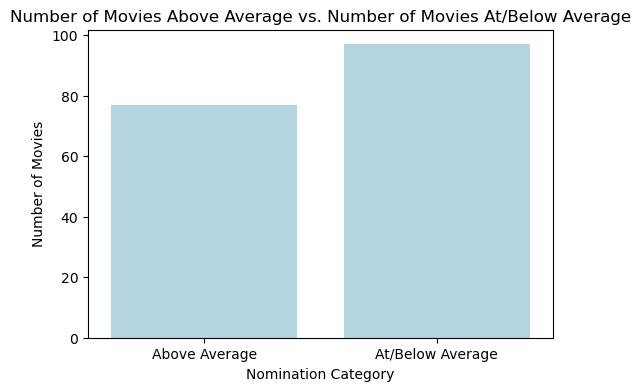

In [94]:
# import matplotlib and seaborn
import matplotlib.pyplot as plt
import seaborn as sns

# create a column that categorizes nominations based on the average we found (use if/else)
integrated_films['Nominations_Category'] = integrated_films['Nominations'].apply(
    lambda x: 'Above Average' if x > 5.33 else 'At/Below Average'
)

# plot the bar chart
plt.figure(figsize = (6, 4))
sns.countplot(x = 'Nominations_Category', data = integrated_films, color = 'lightblue')
plt.title('Number of Movies Above Average vs. Number of Movies At/Below Average')
plt.xlabel('Nomination Category')
plt.ylabel('Number of Movies')
plt.show()

It looks like the number of nominations above the 5.33 average is around 80 and the number of nominations at/below the 5.33 average is around 100. Let's get exact numbers!

In [97]:
# get the exact number of nominations above or below the average
nomination_counts = integrated_films['Nominations_Category'].value_counts()

# print the results
print(f"Here is the number of movies in each category: {nomination_counts}")

Here is the number of movies in each category: Nominations_Category
At/Below Average    97
Above Average       77
Name: count, dtype: int64


Looking at the chart and additional calculations, more movies are at/below the average of 5.33 nominations. There is a difference of 20 movies between the two categories.

#### Bivariate Analysis

Are movies with longer run times more popular than movies with shorter run times or vice versa? This analysis question requires to analyze both the Run_Time_Minutes column and the Score column.

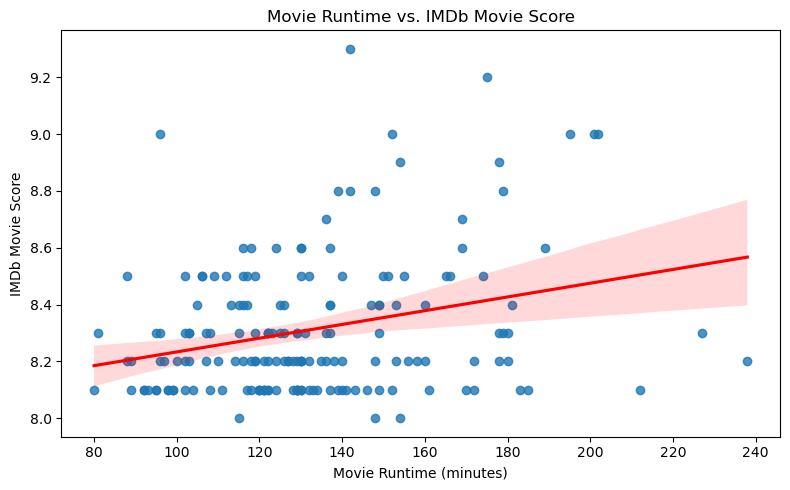

In [104]:
# create a scatter plot with a trend line to identify a trend
plt.figure(figsize = (8, 5))
sns.regplot(x = 'Run_Time_Minutes', y = 'Score', data = integrated_films, line_kws = {'color': 'red'})
plt.title('Movie Runtime vs. IMDb Movie Score')
plt.xlabel('Movie Runtime (minutes)')
plt.ylabel('IMDb Movie Score')
plt.tight_layout()
plt.show()

#### The scatter plot does illustrate a weak positive relationship between Movie Runtime and IMDb Movie Score so more calculations are needed to finalize if this trend is correct 
- If the correlation coefficient is close to +1 then longer movies will score higher
- If the correlation coefficient is close to -1 then longer movies tend to score lower
- If the correlation coefficient is close to 0 then there is no clear relationship

In [107]:
# find the correlation coefficient
correlation = integrated_films['Run_Time_Minutes'].corr(integrated_films['Score'])

# show the results
print(f"The correlation between Movie Runtime and IMDb Movie Score is: {correlation:.2f}")

The correlation between Movie Runtime and IMDb Movie Score is: 0.28


The correlation coefficient is 0.28 which confirms what the scatter plot illustrates, that there is no storng or meaningful correlation. Longer movies aren't necessarily more popular than shorter movies and runtime doesn't reliably predict higher IMDb ratings.

#### Hypothesis Test (Two Sample T-test)

How many Oscars has each movie won and how many nominations has each movie received – and are movies with Oscars wins more popular than movies without wins?

In [116]:
# import packages
from scipy import stats

In [118]:
# read in Horizontal_Integrated_Films.csv
data = pd.read_csv('Horizontal_Integration_Films.csv')

# display the csv file
data

,Movie_Name,Year,Run_Time_Minutes,Score,Winner,Nominations,Winners
0,The Shawshank Redemption,1994,142,9.3,False,7,0
1,The Godfather,1972,175,9.2,True,11,3
2,The Dark Knight,2008,152,9.0,True,8,2
3,The Godfather Part II,1974,202,9.0,False,11,6
4,12 Angry Men,1957,96,9.0,False,3,0
...,...,...,...,...,...,...,...
169,The Grapes of Wrath,1940,129,8.1,False,7,2
170,Into the Wild,2007,148,8.0,False,2,0
171,The Help,2011,146,8.1,False,4,1
172,Amores Perros,2000,154,8.0,False,1,0


#### First create a chart showing how many wins and nominations each movie has received

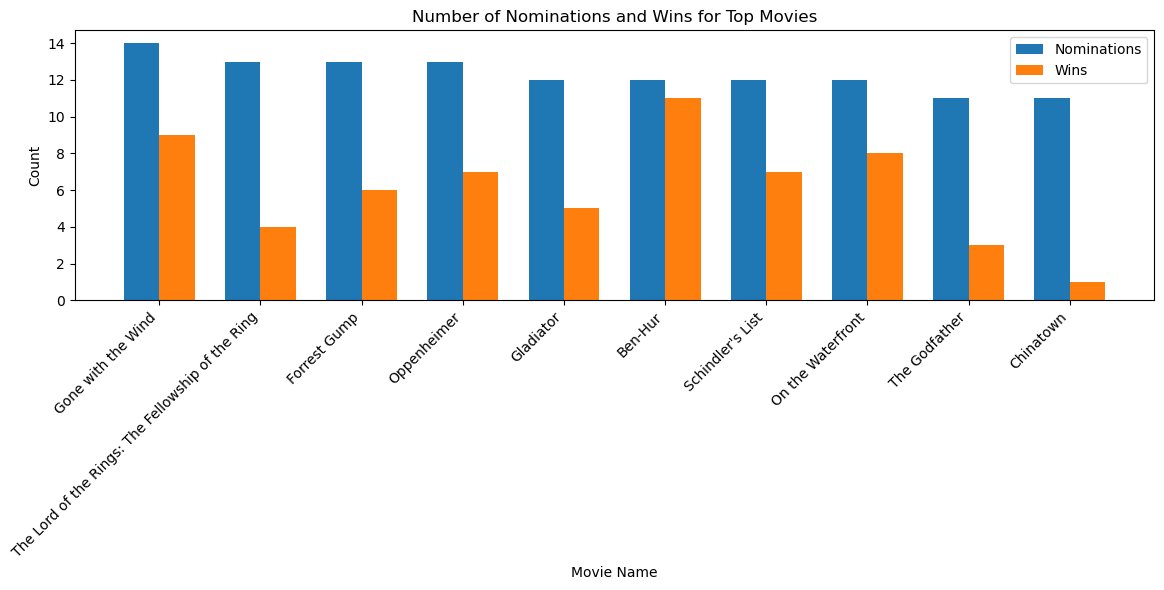

In [127]:
# select only the columns needed
movies = integrated_films[['Movie_Name', 'Nominations', 'Winners']]

# sort to show top movies
movies = movies.sort_values('Nominations', ascending=False).head(10) # only do the top 10 for readability purposes

# set up positions
x = np.arange(len(movies))
width = 0.35

# plot
fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, movies['Nominations'], width, label='Nominations')
rects2 = ax.bar(x + width/2, movies['Winners'], width, label='Wins')

# add labels and a title
ax.set_ylabel('Count')
ax.set_xlabel('Movie Name')
ax.set_title('Number of Nominations and Wins for Top Movies')
ax.set_xticks(x)
ax.set_xticklabels(movies['Movie_Name'], rotation=45, ha='right')
ax.legend()
plt.tight_layout()
plt.show()

In [129]:
# split into two groups to see if movies that won awards have a higher IMDb score
winners = data[data['Winner'] == True]['Score']
non_winners = data[data['Winner'] == False]['Score']

In [131]:
# perform t-test
t_stat, p_value = stats.ttest_ind(winners, non_winners, equal_var = False)
print(f't_statistic: {t_stat:.4f}')
print(f'p_value: {p_value:.4f}')

t_statistic: 1.0580
p_value: 0.2925


In [133]:
# print out whether or not the p_value is statistically significant
alpha = 0.05
if p_value < alpha:
    print('The result is statistically significant. Award-winning movies have different performance compare to non-winners.')
else:
    print('The result is not statistically significant. Award-winning movies and non-winners have similar performance.')

The result is not statistically significant. Award-winning movies and non-winners have similar performance.


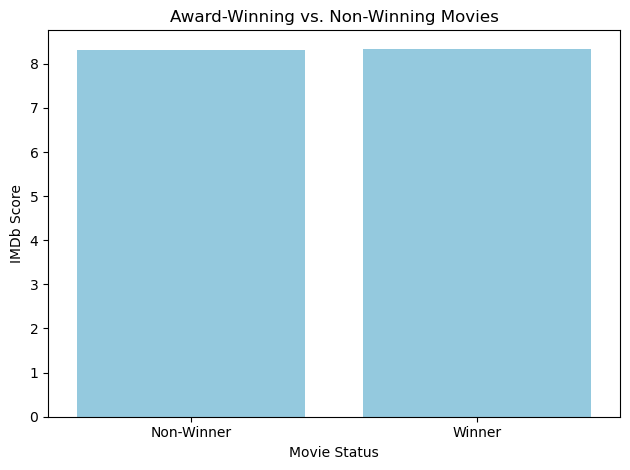

In [255]:
# new labels
data['Winner_Label'] = data['Winner'].replace({True: 'Winner', False: 'Non-Winner'})

# create a bar chart for data
sns.barplot(data = data, x = 'Winner_Label', y = 'Score', errorbar = None, color = 'skyblue')
plt.title('Award-Winning vs. Non-Winning Movies')
plt.xlabel('Movie Status')
plt.ylabel('IMDb Score')
plt.tight_layout()
plt.show()

#### Machine Learning

Are older movies (before the year 2000) more popular than newer movies (after the year 2000)?

#### Use Year and other features to see if a movie is popular or not
- Label a movie as "popular" if its Score is greater than or equal to 8.5
- Label a movie as "not popular" if its Score is less than 8.5

In [153]:
integrated_films['Popularity_Label'] = integrated_films['Score'].apply(lambda x: 'Popular' if x >= 8.5 else 'Not Popular')

#### Use Logistic Regression

In [156]:
# import packages needed for the regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

# select features and target
X = integrated_films[['Year']]
y = integrated_films['Popularity_Label']

# conduct the split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

# train the model
model = LogisticRegression(class_weight = 'balanced')
model.fit(X_train, y_train)

# get prediction
y_pred = model.predict(X_test)

# assess the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Logistic Regression Accuracy: {accuracy:.2f}")

Logistic Regression Accuracy: 0.47


This tells us that our model is 47% accurate at using Year to see if newer or older movies are more popular. 47% accuracy is not good and this is most likely because we're only using one factor (Year). We want accuracy as close to 100% as possible and because the percentage is below 60%, we can conclude that Year alone can't predict the popularity of a movie. We need to add in another factor for analysis.

#### Look at the coefficient to see if newer or older movies are more popular
- A positive coefficient means newer movies are more popular because as Year increases the probability of being "popular" goes up
- A negative coefficient means older movies are more popular because as Year increases the probability of being "popular" goes down

In [160]:
print("Model coefficient for Year:", model.coef_[0][0])

Model coefficient for Year: 0.00827236597591545


We got a positive coefficient of approximately 0.0083. This means that according to Year, newer movies are slightly more popular than older movies. However, the coefficient is small which indicates that the relationship is weak.

#### Get the F1 score

In [164]:
print("Linear Regression F1 Score:", round(f1_score(y_test, y_pred, pos_label = "Popular"), 2))

Linear Regression F1 Score: 0.46


The F1 score approximately 0.46. This means the model has moderate ability to correctly identify which movies are more popular. However, this F1 score is still pretty low which means Year by itself may not be an accurate predictor of popularity.

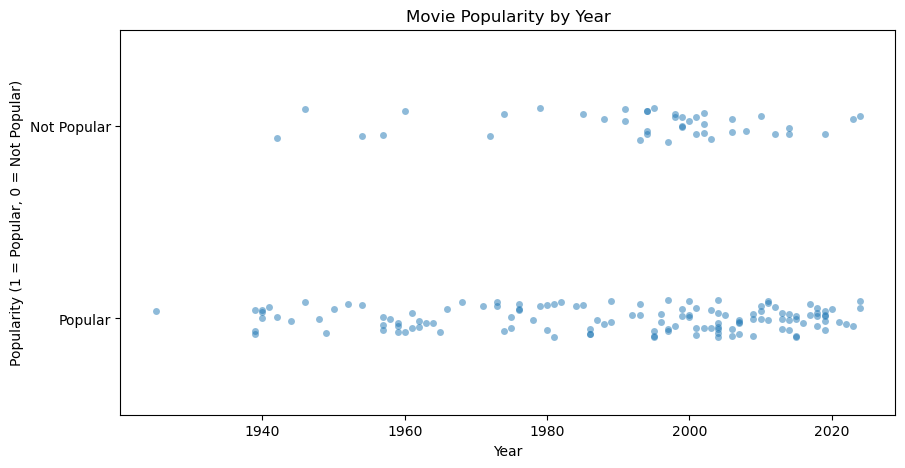

In [167]:
plt.figure(figsize = (10, 5))
sns.stripplot(x = 'Year', y = 'Popularity_Label', data = integrated_films, jitter = True, alpha = 0.5)
plt.title('Movie Popularity by Year')
plt.ylabel('Popularity (1 = Popular, 0 = Not Popular)')
plt.xlabel('Year')
plt.yticks([0, 1], ['Not Popular', 'Popular'])
plt.show()

The scatter plot does show a higher volume of popular movies after the year 2000. We will run more tests to see if this analysis is correct.

#### Decision Tree

In [171]:
# import the necessary packages
from sklearn.tree import DecisionTreeClassifier

# select the features and target
X = integrated_films[['Year']]
y = integrated_films['Popularity_Label']

# perform the split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

# train the model
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train, y_train)

# get prediciton
y_pred = tree_model.predict(X_test)

# assess the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Decision Tree Accuracy: {accuracy:.2f}")

Decision Tree Accuracy: 0.70


This tells us that our model is 70% accurate at using Year to see if newer or older movies are more popular. 70% is above the 46% we got from the logistic regression model so it's a fairly good predictor of if Year plays a role in movie popularity.

#### Get the F1 Score

In [175]:
f1 = f1_score(y_test, y_pred, pos_label = 'Popular')
print(f"Decision Tree F1 Score: {f1:.2f}")

Decision Tree F1 Score: 0.20


The F1 score is approximately 0.20. This is a very low F1 score which indicates that the model does get some predictions right, but could be predicting a lot of "Popular" movies incorrectly.

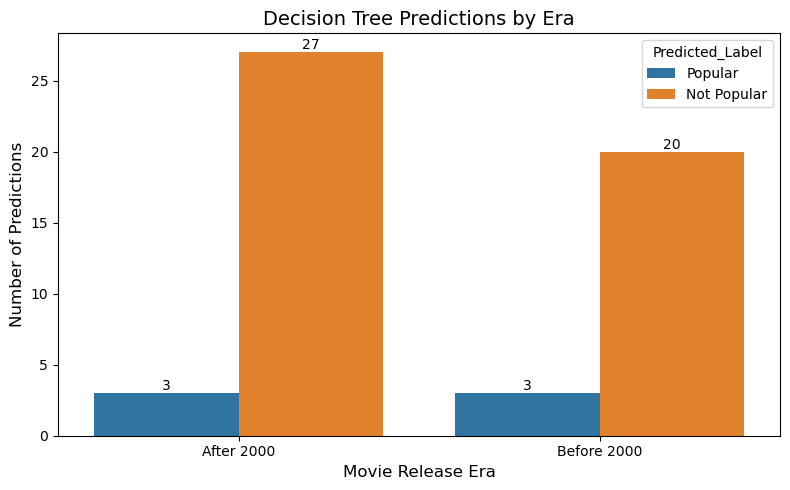

In [179]:
# combine test data with predictions
results_df = X_test.copy()
results_df['True_Label'] = y_test
results_df['Predicted_Label'] = y_pred
results_df['Era'] = results_df['Year'].apply(lambda y: 'Before 2000' if y < 2000 else 'After 2000')

# create a bar chart and assign to ax
plt.figure(figsize=(8, 5))
ax = sns.countplot(data=results_df, x = 'Era', hue = 'Predicted_Label')

# set title and axis labels
plt.title('Decision Tree Predictions by Era', fontsize = 14)
plt.ylabel('Number of Predictions', fontsize = 12)
plt.xlabel('Movie Release Era', fontsize = 12)

# annotate each bar with its value
for container in ax.containers:
    ax.bar_label(container, label_type = 'edge', fontsize = 10)

plt.tight_layout()
plt.show()

This bar chart shows the results from our Decision Tree analysis. It aligns with the low F1 score and tells us there is some imbalance and bias towards predicting movies as "Not Popular." It shows that Year alone is not a strong predictor of popularity.

#### KNN

In [183]:
# import the necessary packages
from sklearn.neighbors import KNeighborsClassifier

# select features and target
X = integrated_films[['Year']]
y = integrated_films['Popularity_Label']

# perform the split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

# train the model
knn_model = KNeighborsClassifier(n_neighbors = 5)
knn_model.fit(X_train, y_train)

# get prediction
y_pred = knn_model.predict(X_test)

# assess the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"KNN Accuracy: {accuracy:.2f}")

KNN Accuracy: 0.75


The KNN model has an accuracy of 75%, the highest one so far. This means the model predicted popularity for 75% of the movies and shows that there is some pattern between Year and popularity. However, we will want to check the F1 score just to be safe.

#### Get F1 Score

In [187]:
f1 = f1_score(y_test, y_pred, pos_label='Popular')
print(f"KNN F1 Score: {f1:.2f}")

KNN F1 Score: 0.38


Even though our KNN model has 75% accuracy, its F1 score of 0.38 is low but the highest one yet. This shows that the model is not good at identifying "Popular" movies and could be imbalanced. We will run another KNN test and balance our data to see if we get better results.

#### KNN Part 2

In [192]:
# import the necessary package
from sklearn.utils import resample

# combine features and labels into one DataFrame
train_df = X_train.copy()
train_df['Popularity_Label'] = y_train

# separate the majority and minority classes
majority = train_df[train_df['Popularity_Label'] == 'Not Popular']
minority = train_df[train_df['Popularity_Label'] == 'Popular']

# upsample the minority class
minority_upsampled = resample(minority,
                              replace=True,         # sample with replacement
                              n_samples=len(majority),  # match majority count
                              random_state=42)

# combine them back together using concat
balanced_df = pd.concat([majority, minority_upsampled])

# split them back into X and y variables
X_train_balanced = balanced_df[['Year']]
y_train_balanced = balanced_df['Popularity_Label']

# retrain the model using the balanced data
knn_model.fit(X_train_balanced, y_train_balanced)

# get a new prediction
y_pred = knn_model.predict(X_test)

# now assess the new accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"KNN Part 2 Accuracy: {accuracy:.2f}")

KNN Part 2 Accuracy: 0.70


The accuracy score went down to 70%. This is completely normal and shows that the model is now predicting both classes fairly.

#### Get the F1 Score

In [197]:
f1 = f1_score(y_test, y_pred, pos_label='Popular')
print(f"KNN Part 2 F1 Score: {f1:.2f}")

KNN Part 2 F1 Score: 0.47


The F1 score is now 0.47 which is an increase from the previous one. This shows that the model is better at identifying "Popular" movies and is more fair. However, the F1 score is still relatively low which means Year alone is not the most reliable predictor of movie popularity. 

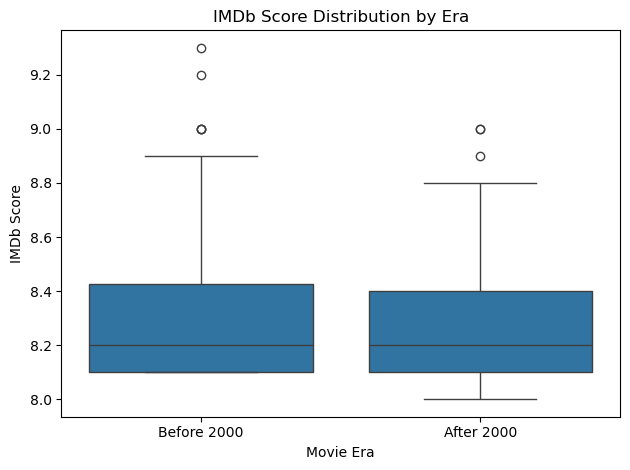

In [202]:
integrated_films['Era'] = integrated_films['Year'].apply(lambda x: 'Before 2000' if x < 2000 else 'After 2000')
sns.boxplot(data=integrated_films, x='Era', y='Score')
plt.title('IMDb Score Distribution by Era')
plt.xlabel('Movie Era')
plt.ylabel('IMDb Score')
plt.tight_layout()
plt.show()

This boxplot tells us that the median score (the line in the blue box) is very similar for both groups and appears to be around 8.2. The height of the box, or the interquartile range (IQR), is also very similar between both groups. The whisker on the Before 2000 box is slightly longer than the one on the After 2000 box and the outliers (dots above the whiskers) show that there are a few very high rated movies in each category. Based on this boxplot, there is no significant difference in IMDb score between each category meaning that Year alone is not a very good predictor of movie popularity.

#### Sentiment Analysis

In [206]:
# import the necessary packages
from textblob import TextBlob

# perform sentiment analysis
def analyze_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity, blob.sentiment.subjectivity

integrated_films[['polarity', 'subjectivity']] = integrated_films['Movie_Name'].apply(
    lambda x: pd.Series(analyze_sentiment(x))
)

display(integrated_films.head(15))

,Movie_Name,Year,Run_Time_Minutes,Score,Winner,Nominations,Winners,Nominations_Category,Popularity_Label,Era,polarity,subjectivity
0,The Shawshank Redemption,1994,142,9.3,False,7,0,Above Average,Popular,Before 2000,0.00,0.0
1,The Godfather,1972,175,9.2,True,11,3,Above Average,Popular,Before 2000,0.00,0.0
2,The Dark Knight,2008,152,9.0,True,8,2,Above Average,Popular,After 2000,-0.15,0.4
3,The Godfather Part II,1974,202,9.0,False,11,6,Above Average,Popular,Before 2000,0.00,0.0
4,12 Angry Men,1957,96,9.0,False,3,0,At/Below Average,Popular,Before 2000,-0.50,1.0
5,The Lord of the Rings: The Return of the King,2003,201,9.0,True,11,11,Above Average,Popular,After 2000,0.00,0.0
6,Schindler's List,1993,195,9.0,False,12,7,Above Average,Popular,Before 2000,0.00,0.0
7,Pulp Fiction,1994,154,8.9,False,7,1,Above Average,Popular,Before 2000,0.00,0.0
8,The Lord of the Rings: The Fellowship of the Ring,2001,178,8.9,False,13,4,Above Average,Popular,After 2000,0.00,0.0
9,Forrest Gump,1994,142,8.8,True,13,6,Above Average,Popular,Before 2000,0.00,0.0


In [208]:
highest_polarity = integrated_films['polarity'].max()
lowest_polarity = integrated_films['polarity'].min()

# filter comments with those scores
highest_polarity_comments = integrated_films[integrated_films['polarity'] == highest_polarity][['Movie_Name', 'Year', 'Run_Time_Minutes', 'Score', 'Winner', 'Nominations', 'Winners', 'Nominations_Category', 'Popularity_Label']]
lowest_polarity_comments = integrated_films[integrated_films['polarity'] == lowest_polarity][['Movie_Name', 'Year', 'Run_Time_Minutes', 'Score', 'Winner', 'Nominations', 'Winners', 'Nominations_Category', 'Popularity_Label']]

# lowest polarity score
print(f"Lowest Polarity Score: {lowest_polarity}")
print(f"Comments with the Lowest Polarity Score:")
print(lowest_polarity_comments)
print(f"\n")

# highest polarity score
print(f"Highest Polarity Score: {highest_polarity}")
print(f"Comments with the Highest Polarity Score:")
print(highest_polarity_comments)
print("\n")

Lowest Polarity Score: -0.625
Comments with the Lowest Polarity Score:
             Movie_Name  Year  Run_Time_Minutes  Score  Winner  Nominations  \
128  Mad Max: Fury Road  2015               120    8.1   False           10   

     Winners Nominations_Category Popularity_Label  
128        6        Above Average      Not Popular  


Highest Polarity Score: 1.0
Comments with the Highest Polarity Score:
                      Movie_Name  Year  Run_Time_Minutes  Score  Winner  \
15         It's a Wonderful Life  1946               130    8.6   False   
159  The Best Years of Our Lives  1946               170    8.1    True   

     Nominations  Winners Nominations_Category Popularity_Label  
15             5        0     At/Below Average          Popular  
159            9        8        Above Average      Not Popular  




In [210]:
# average polarity
mean_polarity = integrated_films['polarity'].mean()
print(f"Average Polarity: {mean_polarity}")

# average subjectivity
mean_subjectivity = integrated_films['subjectivity'].mean()
print(f"Average Subjectivity: {mean_subjectivity}")

Average Polarity: 0.03601532567049809
Average Subjectivity: 0.10735153256704981


In [212]:
# are the sentiment counts positive, neagtive, or neutral
integrated_films['sentiment_category'] = integrated_films['polarity'].apply(
    lambda x: 'positive' if x > 0 else ('negative' if x < 0 else 'neutral')
)
sentiment_counts = integrated_films['sentiment_category'].value_counts()
print(sentiment_counts)

sentiment_category
neutral     144
positive     19
negative     11
Name: count, dtype: int64


In [214]:
# subjectivity of the integrated films
highly_subjective = integrated_films[integrated_films['subjectivity'] > 0.9]
print("Highly Subjective Comments:")
print(highly_subjective[['Movie_Name', 'subjectivity']])

Highly Subjective Comments:
                   Movie_Name  subjectivity
4                12 Angry Men           1.0
15      It's a Wonderful Life           1.0
20          Life Is Beautiful           1.0
23              Spirited Away           1.0
105          A Beautiful Mind           1.0
128        Mad Max: Fury Road           1.0
134  The Grand Budapest Hotel           1.0


In [216]:
# average sentiments per year
avg_sentiments_by_year = integrated_films.groupby('Year').agg({
    'polarity': 'mean',
    'subjectivity': 'mean'
})
print(avg_sentiments_by_year)

      polarity  subjectivity
Year                        
1925  0.000000      0.000000
1939  0.000000      0.000000
1940  0.266667      0.250000
1941  0.000000      0.000000
1942  0.000000      0.000000
...        ...           ...
2020  0.000000      0.000000
2021  0.000000      0.000000
2022  0.500000      0.500000
2023  0.000000      0.000000
2024  0.033333      0.133333

[74 rows x 2 columns]


In [218]:
# correlation between nominations and polarity
correlation = integrated_films['Nominations'].corr(integrated_films['polarity'])
print(f"Correlation between Nominations and Polarity: {correlation}")

Correlation between Nominations and Polarity: 0.05352792793595067


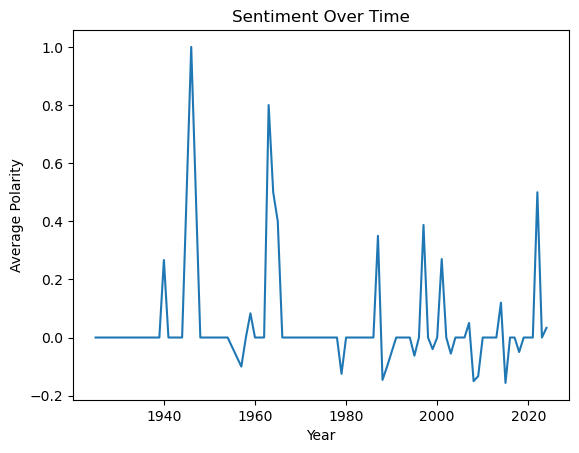

In [220]:
# sentiment over time for 'Year'
sentiment_over_time = integrated_films.groupby(integrated_films['Year'])['polarity'].mean()
sentiment_over_time.plot()
plt.title("Sentiment Over Time")
plt.xlabel("Year")
plt.ylabel("Average Polarity")
plt.show()